In [1]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import pandas as pd
import os
import math
from scipy.ndimage import gaussian_filter
from sklearn.preprocessing import OneHotEncoder
import random
from keras.utils.np_utils import to_categorical   
from tensorflow.keras.models import load_model
from keras.callbacks import ModelCheckpoint
from keras import backend as K
from sklearn.neighbors import KNeighborsClassifier
from sklearn.utils import class_weight

# Data Loading 

In [2]:
X_path = "/content/drive/MyDrive/dataset/X"
Y_path = "/content/drive/MyDrive/dataset/Y"

In [3]:
X_val_path = "/content/drive/MyDrive/val_dataset/X"
Y_val_path = "/content/drive/MyDrive/val_dataset/Y"

In [4]:
X_val_name_list  = os.listdir(X_val_path)
Y_val_name_list = os.listdir(Y_val_path)

In [5]:
print(len(X_val_name_list))

2000


In [6]:
X_name_list  = os.listdir(X_path)
Y_name_list = os.listdir(Y_path)

In [7]:
X_val_name_list.sort()
Y_val_name_list.sort()

In [8]:
X_name_list.sort()
Y_name_list.sort()

In [9]:
print(X_name_list[0:10] , Y_name_list[0:10])

['melspec_0.npy', 'melspec_1.npy', 'melspec_10.npy', 'melspec_100.npy', 'melspec_1000.npy', 'melspec_1001.npy', 'melspec_1002.npy', 'melspec_1003.npy', 'melspec_1004.npy', 'melspec_1005.npy'] ['eventroll_0.npy', 'eventroll_1.npy', 'eventroll_10.npy', 'eventroll_100.npy', 'eventroll_1000.npy', 'eventroll_1001.npy', 'eventroll_1002.npy', 'eventroll_1003.npy', 'eventroll_1004.npy', 'eventroll_1005.npy']


In [10]:
sample_spectrogram = np.load(os.path.join(X_path , X_name_list[180]) , allow_pickle = True) 
sample_label = np.load(os.path.join(Y_path , Y_name_list[180]) , allow_pickle = True) 

# Some Basic Functions

In [11]:
def addDim(mat) :
  return np.expand_dims(mat , axis = 2)
def reduceDim(mat) :
  return mat[0]

In [12]:
def plotSpectrogram(comp ,mat , title1 , mat2= None , title2=None ) :
  if comp == False :
    plt.pcolor(mat , cmap = 'plasma')
    plt.title(title1)
    plt.show()
  else :
    plt.figure(figsize=(16,8))
    plt.subplot(1,2,1) 
    plt.pcolor(mat , cmap = 'plasma')
    plt.title(title1)
    plt.subplot(1,2,2)
    plt.pcolor(mat2 , cmap = 'plasma')
    plt.title(title2)
    plt.show()

In [13]:
events_types = {
    0: 'Alarm_bell_ringing', 
    1: 'Blender', 
    2: 'Cat', 
    3: 'Dishes', 
    4: 'Dog',
    5: 'Electric_shaver_toothbrush', 
    6: 'Frying', 
    7: 'Running_water',
    8: 'Speech', 
    9: 'Vacuum_cleaner'
}


In [14]:
def eventroll_to_multihot_vector(eventroll):
    """
    Parameters
    ----------
    eventroll : np.array
        Eventroll matrix of shape=(11, 1000).
    
    Returns
    -------
    np.array
        A multihot vector of shape=(10,)
    """
    
    # findout active events:
    active_events = (eventroll.sum(axis=1) >= 0.5).astype('float')
    
    # remove silence class:
    return np.delete(active_events, 8)

In [15]:
sample_vector = eventroll_to_multihot_vector(sample_label)

In [16]:
print(np.min(sample_spectrogram))

0.00010967552


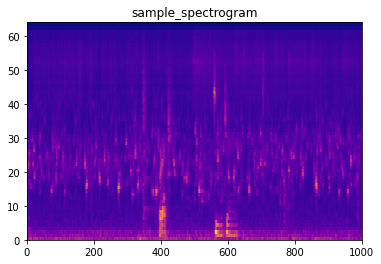

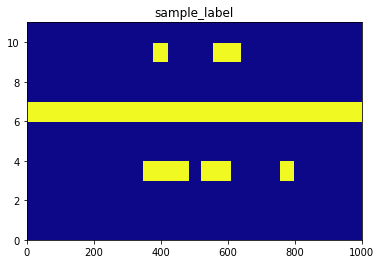

[0. 0. 0. 1. 0. 0. 1. 0. 1. 0.]


In [17]:
plotSpectrogram(False, reduceDim(sample_spectrogram) , "sample_spectrogram")
plotSpectrogram(False , sample_label ,  "sample_label")
print(sample_vector)

In [ ]:
X = []
Y = []
for i in X_name_list :
  X.append(np.load(os.path.join(X_path , i) , allow_pickle = True))
for i in Y_name_list :
  Y.append(np.load(os.path.join(Y_path , i), allow_pickle = True))
X = np.array(X)
Y = np.array(Y)
np.save("/content/drive/MyDrive/X.npy" , X ) 
np.save("/content/drive/MyDrive/Y.npy" , Y ) 

In [18]:
X = np.load("/content/drive/MyDrive/X.npy")

In [19]:
X_copy = []

In [20]:
for i in X :
  X_copy.append(addDim(reduceDim(i)))

In [21]:
X_copy = np.array(X_copy)

In [22]:
print(np.shape(X_copy[1]))

(64, 1000, 1)


In [ ]:
X_val = []
Y_val = []

for i in X_val_name_list :
  X_val.append(np.load(os.path.join(X_val_path , i) , allow_pickle = True))
for i in Y_val_name_list :
  Y_val.append(np.load(os.path.join(Y_val_path , i), allow_pickle = True))
X_val = np.array(X_val)
Y_val = np.array(Y_val)
np.save("/content/drive/MyDrive/X_val.npy" , X_val ) 
np.save("/content/drive/MyDrive/Y_val.npy" , Y_val ) 

In [23]:
X =  np.load("/content/drive/MyDrive/X.npy")
Y = np.load("/content/drive/MyDrive/Y.npy")

In [24]:
Y_multihot = []
for i in Y :
  Y_multihot.append(eventroll_to_multihot_vector(i))
Y_multihot  = np.array(Y_multihot)

In [25]:
print( np.shape(Y_multihot))

(10000, 10)


In [26]:
X_val =  np.load("/content/drive/MyDrive/X_val.npy")
Y_val = np.load("/content/drive/MyDrive/Y_val.npy")

In [27]:
X_val_copy = []
for i in X_val :
  X_val_copy.append(addDim(reduceDim(i)))
X_val_copy = np.array(X_val_copy)

In [28]:
print(np.shape(X_val_copy[1]))


(64, 1000, 1)


In [29]:
Y_val_multihot = []
for i in Y_val :
  Y_val_multihot.append(eventroll_to_multihot_vector(i))
Y_val_multihot  = np.array(Y_val_multihot)

In [30]:
print( np.shape(Y_val_multihot))


(2000, 10)


In [31]:
from sklearn.metrics import f1_score,precision_score,recall_score

In [32]:
t = Y_multihot.sum(axis =0)
print(t)

[1499.  993. 1128. 2440. 1412. 1096. 1349. 1219. 9201. 1046.]


# Training

In [33]:
def cnn_model() :
  cnn = Sequential()
  cnn.add(layers.Conv2D(16,(3,3),(2,2), padding = 'same' , activation = 'relu' ,input_shape = (64,1000,1,)))
  cnn.add(layers.BatchNormalization())
  cnn.add(layers.MaxPool2D())
  cnn.add(layers.BatchNormalization())
  cnn.add(layers.Conv2D(32 , (3,3) ,padding = 'same' , activation = 'relu'))
  cnn.add(layers.BatchNormalization())
  cnn.add(layers.MaxPool2D())
  cnn.add(layers.BatchNormalization())
  cnn.add(layers.Conv2D(64 , (3,3) ,(2,2), padding = 'same' , activation = 'relu'))
  cnn.add(layers.BatchNormalization())
  cnn.add(layers.Conv2D(64 , (3,3) , padding = 'same'))
  cnn.add(layers.BatchNormalization())
  cnn.add(layers.GlobalAveragePooling2D())
  cnn.add(layers.Dense(128 , activation = 'relu'))
  cnn.add(layers.Dense(10 , activation = 'sigmoid'))
  cnn.summary()
  return cnn

In [34]:
cnn = cnn_model()


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 32, 500, 16)       160       
                                                                 
 batch_normalization (BatchN  (None, 32, 500, 16)      64        
 ormalization)                                                   
                                                                 
 max_pooling2d (MaxPooling2D  (None, 16, 250, 16)      0         
 )                                                               
                                                                 
 batch_normalization_1 (Batc  (None, 16, 250, 16)      64        
 hNormalization)                                                 
                                                                 
 conv2d_1 (Conv2D)           (None, 16, 250, 32)       4640      
                                                        

In [35]:
cnn.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-3), loss= 'binary_crossentropy' , metrics=['binary_accuracy'] )

In [36]:
history = cnn.fit(
    x = X_copy , y = Y_multihot,
    validation_split = 0.4,
    epochs = 15 , 
    steps_per_epoch = 50,
    batch_size = 32,
)

Epoch 1/15
50/50 [==============================] - 56s 1s/step - loss: 0.4314 - binary_accuracy: 0.8456 - val_loss: 0.4489 - val_binary_accuracy: 0.8710
Epoch 2/15
50/50 [==============================] - 53s 1s/step - loss: 0.3436 - binary_accuracy: 0.8717 - val_loss: 0.4862 - val_binary_accuracy: 0.8710
Epoch 3/15
50/50 [==============================] - 54s 1s/step - loss: 0.3219 - binary_accuracy: 0.8793 - val_loss: 0.5779 - val_binary_accuracy: 0.8710
Epoch 4/15
50/50 [==============================] - 53s 1s/step - loss: 0.3215 - binary_accuracy: 0.8770 - val_loss: 0.6689 - val_binary_accuracy: 0.7900
Epoch 5/15
50/50 [==============================] - 54s 1s/step - loss: 0.3077 - binary_accuracy: 0.8818 - val_loss: 0.5665 - val_binary_accuracy: 0.8708
Epoch 6/15
50/50 [==============================] - 53s 1s/step - loss: 0.3010 - binary_accuracy: 0.8853 - val_loss: 0.8297 - val_binary_accuracy: 0.7955
Epoch 7/15
50/50 [==============================] - 55s 1s/step - loss: 0.28

In [37]:
def crnn() :
  # def model1() :
  model = Sequential()
  model.add(layers.Conv2D(1,(3,3),(3,1), padding = 'same' , activation = 'relu' ,input_shape = (64,1000,1,)))
  model.add(layers.Conv2D(1,(3,3),(3,2), padding = 'same' , activation = 'relu'))
  # model.add(layers.Conv2D(1,(3,1),(3,1), padding = 'same' , activation = 'relu'))
  model.add(layers.Flatten())
  model.add(layers.Embedding( input_dim = 4000 ,output_dim= 500))
  model.add(layers.SimpleRNN(128))
  model.add(layers.Dense(10 , activation = 'sigmoid'))
  model.summary()
  return model 

In [38]:
crnn = crnn()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_4 (Conv2D)           (None, 22, 1000, 1)       10        
                                                                 
 conv2d_5 (Conv2D)           (None, 8, 500, 1)         10        
                                                                 
 flatten (Flatten)           (None, 4000)              0         
                                                                 
 embedding (Embedding)       (None, 4000, 500)         2000000   
                                                                 
 simple_rnn (SimpleRNN)      (None, 128)               80512     
                                                                 
 dense_2 (Dense)             (None, 10)                1290      
                                                                 
Total params: 2,081,822
Trainable params: 2,081,822
No

In [40]:
crnn.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-3), loss= 'binary_crossentropy' , metrics=['binary_accuracy'])

In [41]:
history = crnn.fit(
    x = X_copy , y = Y_multihot,
    validation_split = 0.2,
    epochs = 10 , 
    steps_per_epoch = 50,
    batch_size = 32,

)

Epoch 1/10


50/50 [==============================] - 375s 7s/step - loss: 0.4038 - binary_accuracy: 0.8658 - val_loss: 0.3835 - val_binary_accuracy: 0.8701
Epoch 2/10
50/50 [==============================] - 372s 7s/step - loss: 0.3796 - binary_accuracy: 0.8710 - val_loss: 0.3808 - val_binary_accuracy: 0.8701
Epoch 3/10
50/50 [==============================] - 364s 7s/step - loss: 0.3808 - binary_accuracy: 0.8710 - val_loss: 0.3831 - val_binary_accuracy: 0.8701
Epoch 4/10
50/50 [==============================] - 365s 7s/step - loss: 0.3840 - binary_accuracy: 0.8683 - val_loss: 0.3826 - val_binary_accuracy: 0.8701
Epoch 5/10
50/50 [==============================] - 367s 7s/step - loss: 0.3810 - binary_accuracy: 0.8697 - val_loss: 0.3811 - val_binary_accuracy: 0.8701
Epoch 6/10
50/50 [==============================] - 365s 7s/step - loss: 0.3823 - binary_accuracy: 0.8687 - val_loss: 0.3805 - val_binary_accuracy: 0.8701
Epoch 7/10
50/50 [==============================] - 362s 7s/step - loss: 0.3855 -

In [42]:
pred_crnn = crnn.predict(x = X_val_copy)
pred_cnn = cnn.predict(x = X_val_copy)

63/63 [==============================] - 11s 165ms/step


In [43]:
print(pred_crnn)

[[0.12342775 0.10952457 0.13388434 ... 0.10861316 0.9205078  0.12997676]
 [0.12342775 0.10952457 0.13388434 ... 0.10861316 0.9205078  0.12997676]
 [0.12342775 0.10952457 0.13388434 ... 0.10861316 0.9205078  0.12997676]
 ...
 [0.12342775 0.10952457 0.13388434 ... 0.10861316 0.9205078  0.12997676]
 [0.12342775 0.10952457 0.13388434 ... 0.10861316 0.9205078  0.12997676]
 [0.12342775 0.10952457 0.13388434 ... 0.10861316 0.9205078  0.12997676]]


In [44]:
a1 = np.where(pred_crnn>=0.45, 1,0)

In [45]:
pred_cnn = cnn.predict(x = X_val_copy)

63/63 [==============================] - 10s 166ms/step


In [46]:
a2 = np.where(pred_cnn>=0.5, 1,0)

In [47]:
from sklearn.metrics import f1_score,precision_score,recall_score

print(precision_score(Y_val_multihot, a1, average='samples'))
print(recall_score(Y_val_multihot, a1 , average='samples'))
print(f1_score(Y_val_multihot, a1, average='samples'))

0.623
0.29043333333333327
0.39035000000000003


In [48]:
print(precision_score(Y_val_multihot, a2, average='samples'))
print(recall_score(Y_val_multihot, a2 , average='samples'))
print(f1_score(Y_val_multihot, a2 , average='samples'))

0.382625
0.43745000000000006
0.3850523809523809


In [49]:
print(a2.sum(axis=0))
print(Y_val_multihot.sum(axis=0))

[  30    0    0 1103    0    0 1260  532 2000    0]
[ 392.  436.  274.  444.  306.  221.  130.  143. 1246.  151.]


In [50]:
x1 = np.load("/content/drive/MyDrive/X.npy")
y1 = np.load("/content/drive/MyDrive/Y.npy")

In [51]:
list_idx = []
for i in range(10000) :
  if (y1[i].sum(axis = 1))[9] >=90 :
    list_idx.append(i)
print(len(list_idx))

8067


In [52]:
for i in list_idx :
  for p in range(1000) :
    if y1[i][9][p] == 1 :
      (x1[i].T)[p] = np.zeros((64,1))
      y1[i][9][p] = 0

In [53]:
np.save("/content/drive/MyDrive/balanced_X.npy" , x1)
np.save("/content/drive/MyDrive/balanced_Y.npy" , y1)

In [ ]:
balanced_x = np.load("/content/drive/MyDrive/balanced_X.npy")
balanced_y = np.load("/content/drive/MyDrive/balanced_Y.npy")

In [ ]:
cnn2 = cnn_model()

In [ ]:
balanced_y_multihot = []
for i in balanced_y :
  balanced_y_multihot.append(eventroll_to_multihot_vector(i))
balanced_y_multihot  = np.array(balanced_y_multihot)

In [ ]:
cnn2.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-3), loss= 'binary_crossentropy' , metrics=['binary_accuracy'] )

In [ ]:
history1 = cnn2.fit(
    x = balanced_x , y = balanced_y_multihot,
    validation_split = 0.2,
    epochs = 15 , 
    steps_per_epoch = 50,
    batch_size = 32,
)

# Validation

In [ ]:
pred_cnn2 = cnn2.predict(x = X_val_copy)


In [ ]:
cnn2.save("/content/drive/MyDrive/cnn_base_25_epochs.h5")

In [ ]:
pred_cnn2 = np.where(pred_cnn2>=0.5, 1,0)

In [ ]:
print(Y_val_multihot.sum(axis=0))
print(pred_cnn2.sum(axis=0))